In [32]:
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler

from sklearn.model_selection import train_test_split
import sklearn.metrics as sm

In [33]:
import os
from os.path import expanduser
home = expanduser("~")
os.chdir(os.path.join(home, 'Documents', 'Projekty', 'handwritting-categorizer'))
print('Current working directory set to:')
os.getcwd()

Current working directory set to:


'C:\\Users\\Asia\\Documents\\Projekty\\handwritting-categorizer'

In [34]:
with open(os.path.join('data', 'raw', 'train.pkl'), 'rb') as f:
    (x_all, y_all) = pickle.load(f)

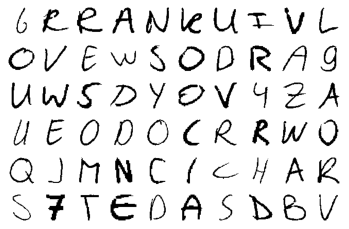

In [35]:
# display some digits
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(x_all[index].reshape((56, 56)), cmap='gray_r')

In [36]:
x_all.shape

(30134, 3136)

In [37]:
y_all.shape

(30134, 1)

In [38]:
y_all

array([[26],
       [ 0],
       [13],
       ...,
       [17],
       [13],
       [ 3]], dtype=int64)

In [39]:
np.unique(y_all, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35], dtype=int64),
 array([ 164,  301, 2014, 1429,  735,  191, 2527,  127, 1175,  324,  343,
         141,  548, 2157, 3291,  179,  664,  841,  425,  152,  332,  394,
        2332,  102,  118, 1442, 1235,  168,  287,  701,    1,  158, 1073,
         561, 1578, 1924], dtype=int64))

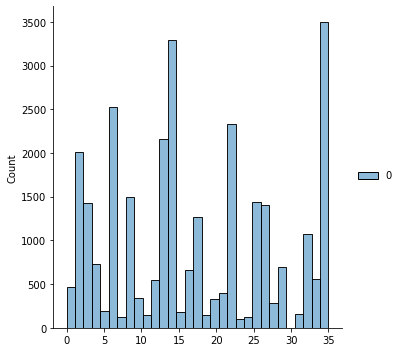

In [40]:
sns.displot(y_all)

In [41]:
x_all = np.reshape(x_all, (-1, 1, 56, 56))
x_all.shape

(30134, 1, 56, 56)

In [42]:
y_all = y_all.ravel()
y_all.shape

(30134,)

In [43]:
random_seed = 234
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size = 0.1, random_state=random_seed)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((27120, 1, 56, 56), (3014, 1, 56, 56), (27120,), (3014,))

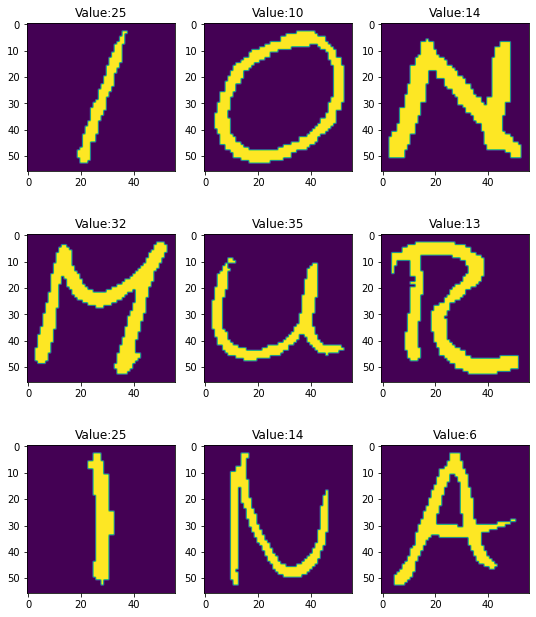

In [44]:
def display(rows, columns, images, values=[], predictions=[]):
    fig = plt.figure(figsize=(9, 11))

    ax = []

    for i in range( columns*rows ):
        img = images[i]
        ax.append(fig.add_subplot(rows, columns, i+1))
        
        title = ""
        
        if(len(values) == 0):
            title = "Pred:" + str(predictions[i])
        elif(len(predictions) == 0):
            title = "Value:" + str(values[i])
        elif(len(values) != 0 and len(predictions) != 0):
            title = "Value:" + str(values[i]) + "\nPred:" + str(predictions[i])
        
        ax[-1].set_title(title)  # set title
        plt.imshow(img)

    plt.show()
    
idx = np.random.randint(1, 1000, size=9)

images = x_train[idx,:]
images = images[:,0]
values = y_train[idx]

display(rows=3, columns=3, images=images, values=values, predictions=[])

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [46]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(10*10*64, 256)
        self.fc2 = nn.Linear(256, 36)

    def forward(self, x):
#         print(x.shape)
        x = F.relu(self.conv1(x))
#         print(x.shape)
        x = F.dropout(x, p=0.5, training=self.training)
#         print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         print(x.shape)
        x = F.dropout(x, p=0.5, training=self.training)
#         print(x.shape)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
#         print(x.shape)
        x = F.dropout(x, p=0.5, training=self.training)
#         print(x.shape)
        x = x.view(-1,10*10*64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
net = Net()

net.to(device)

net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=36, bias=True)
)

In [47]:
torch.Size([32, 1, 56, 56])
torch.Size([32, 32, 52, 52])
torch.Size([32, 32, 52, 52])
torch.Size([32, 32, 24, 24])
torch.Size([32, 32, 24, 24])
torch.Size([32, 64, 10, 10])
torch.Size([32, 64, 10, 10])

torch.Size([32, 64, 10, 10])

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [49]:
class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

In [50]:
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [51]:
from torchsampler import ImbalancedDatasetSampler

ModuleNotFoundError: No module named 'torchsampler'

In [52]:
torch_x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(torch_x_train,torch_y_train)

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle = False, num_workers=2, sampler=sampler) 
#                                            sampler=ImbalancedDatasetSampler(train))

In [54]:
%%time

#Seed
torch.manual_seed(1234)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.view(-1) 
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         print(outputs.shape)
#         print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, loss.item()))
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i, running_loss / 500))
#             running_loss = 0.0

print('Finished Training')

[1,   500] loss: 1.211
[2,   500] loss: 1.250
[3,   500] loss: 0.477
[4,   500] loss: 0.806
[5,   500] loss: 0.823
[6,   500] loss: 0.283
[7,   500] loss: 0.346
[8,   500] loss: 0.532
[9,   500] loss: 0.478
[10,   500] loss: 0.397
Finished Training
CPU times: total: 4min 35s
Wall time: 6min 44s


In [ ]:
#Validate trained model
torch_x_val = torch.from_numpy(x_val).type(torch.FloatTensor)
torch_y_val = torch.from_numpy(y_val).type(torch.LongTensor)

torch_x_val, torch_y_val = torch_x_val.to(device), torch_y_val.to(device)

val = net(torch_x_val)

_, predicted = torch.max(val.data, 1)

#Get accuration
print('Accuracy of the network %d %%' % (100 * torch.sum(torch_y_val==predicted) / len(y_val)))

In [ ]:
import sklearn.metrics as sm
confusion_mtx = sm.confusion_matrix(y_val, predicted)

In [ ]:
cm = confusion_mtx
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
  for j in range(ncols):
      c = cm[i, j]
      p = cm_perc[i, j]
      if c == 0:
          annot[i, j] = ''
      else:
          annot[i, j] = '%.1f%%' % p
classe_labels = range(36)
# cm = pd.DataFrame(cm, index=classe_labels, columns=classe_labels)
cm = pd.DataFrame(cm)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (30,10))
sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")

In [ ]:
# Get random data from the valication dataset and the predicted values
idx = np.random.randint(1, 1000, size=9)

images = x_val[idx,:]
images = images[:,0]

values = y_val[idx]

predicted = predicted.cpu()

predictions = predicted.data.numpy()
predictions = predictions[idx]

display(rows=3, columns=3, images=images, values=values, predictions=predictions)

In [21]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    sampler=ImbalancedDatasetSampler(train_dataset),
    batch_size=args.batch_size,
    **kwargs
)

NameError: name 'train_dataset' is not defined